In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import torch.nn.functional as F

from ex_biology import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun, low_to_high
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from feature_transform import max_transformer

# load results

In [3]:
# wavelet params
waves = ["db3"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_mode=per_seed=1" for wave in waves]

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            wt = DWT1d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [4]:
# define indexes
res = results[0]
mos = models[0]
lamL1wave = np.array(res['lamL1wave'])
lamL1attr = np.array(res['lamL1attr'])
lamL1wave_grid = np.unique(lamL1wave)
lamL1attr_grid = np.unique(lamL1attr)
R = len(lamL1wave_grid)
C = len(lamL1attr_grid)

# original wavelet
wt_o = DWT1d(wave='db5', mode=mode, J=J).to(device)

# collect results
dic = {'psi':{},
       'wt': {},
       'lamL1wave': {},
       'lamL1attr': {},
       'index': {}}

for r in range(R):
    for c in range(C):
        loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
        if loc.sum() == 1: 
            loc = np.argwhere(loc).flatten()[0]
            dic['index'][(r,c)] = loc
            wt = mos[loc]
            _, psi, x = get_wavefun(wt)

            dic['wt'][(r,c)] = wt
            dic['psi'][(r,c)] = psi     
            dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
            dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]


# calculate accuracy

In [5]:
# params for feature transformer
is_abs = False
m = 6

# cross validation
reg = []
log = []
for use_reg in [True, False]:
    (train_loader, test_loader) = get_dataloader(p.data_path, 
                                                 batch_size=p.batch_size,
                                                 is_continuous=use_reg)   
    for i,wt in enumerate(list(dic['wt'].values())):
        wt = wt.to('cpu')
        (X, y), (X_test, y_test) = max_transformer(wt, 
                                                   train_loader, 
                                                   test_loader,
                                                   is_abs=is_abs,
                                                   m=m)
        
        if use_reg:
            clf = LinearRegression()
            scores = cross_val_score(clf, X, y, cv=5, scoring='r2')
            reg.append(scores.mean())
#             clf = LinearRegression().fit(X, y)
#             preds = clf.predict(X_test)
#             reg.append(metrics.r2_score(y_test, preds))
        else:
            clf = LogisticRegression()
            scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
            log.append(scores.mean())
#             clf = LogisticRegression().fit(X, y)
#             preds = clf.predict(X_test)
#             preds = 1 * (preds > 0)
#             log.append(metrics.accuracy_score(y_test, preds))
        print('\rIteration:{}'.format(i), end='')
reg = np.array(reg)
log = np.array(log)

Iteration:104

# regression

wavelet with best regression performance

Hyperparameter: lamL1wave=0.010000 lamL1attr=0.928480
Error: Recon=0.001401
Sparsity: Wave=4.026196
Interp: Saliency=0.352758 InputXGrade=0.298271
Wavelet loss: lSum=0.000000 hsum=0.000058 L2norm=0.000003 CMF=0.000042 Conv=0.000004


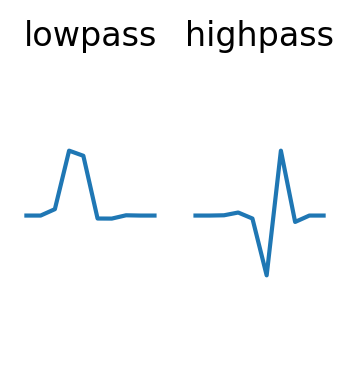

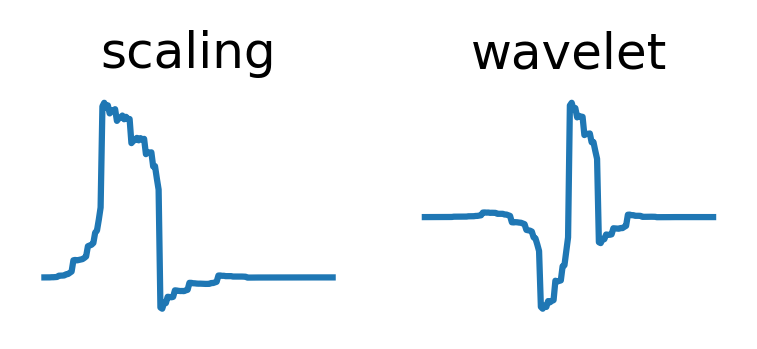

In [6]:
idx1, idx2 = list(dic['index'].keys())[np.argmax(reg).flatten()[0]]
wt = mos[dic['index'][(idx1, idx2)]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][dic['index'][(idx1, idx2)]], res['lamL1attr'][dic['index'][(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][dic['index'][(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][dic['index'][(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][dic['index'][(idx1, idx2)]], res['L1inputxgrad_loss'][dic['index'][(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['hsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['L2norm_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['CMF_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['conv_loss'][dic['index'][(idx1, idx2)]]))


plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

In [7]:
model = load_pretrained_model(p.model_path, device=device)    

r = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': [],    
    'LSTM': [],
}

(train_loader, test_loader) = get_dataloader(p.data_path, 
                             batch_size=p.batch_size,
                             is_continuous=True)   

(X, y), (X_test, y_test) = max_transformer(wt, 
                                           train_loader, 
                                           test_loader,
                                           is_abs=is_abs,
                                           m=m)

clf = LinearRegression().fit(X, y)
preds = clf.predict(X_test)
acc = metrics.r2_score(y_test, preds)
r['AWD (Ours)'].append(acc)

(X, y), (X_test, y_test) = max_transformer(wt_o, 
                                           train_loader, 
                                           test_loader,
                                           is_abs=is_abs,
                                           m=m)

clf_o = LinearRegression().fit(X, y)
preds = clf_o.predict(X_test)
acc = metrics.r2_score(y_test, preds)
r['Standard Wavelet (DB5)'].append(acc)

preds = []
y_test = []
for data, labels in test_loader:   
    preds.append(model(data).detach().numpy())
    y_test.append(labels.detach().numpy())
preds = np.vstack(preds)
y_test = np.vstack(y_test)
acc = metrics.r2_score(y_test, preds)
r['LSTM'].append(acc)

scores = pd.DataFrame.from_dict(r).round(3)
scores.index = ['Regression (R2 score)']
print(scores.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Standard Wavelet (DB5) &  AWD (Ours) &   LSTM \\
\midrule
Regression (R2 score) &                   0.197 &       0.255 &  0.237 \\
\bottomrule
\end{tabular}



# classification

wavelet with best classification performance

Hyperparameter: lamL1wave=0.000100 lamL1attr=9.057900
Error: Recon=0.029578
Sparsity: Wave=4.124960
Interp: Saliency=0.348663 InputXGrade=0.301335
Wavelet loss: lSum=0.000006 hsum=0.001511 L2norm=0.000072 CMF=0.001888 Conv=0.000173


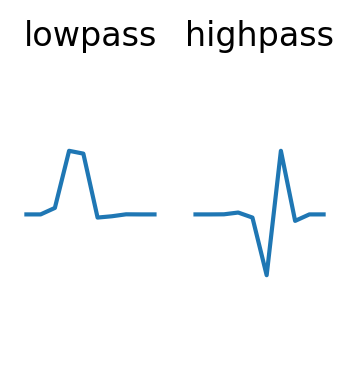

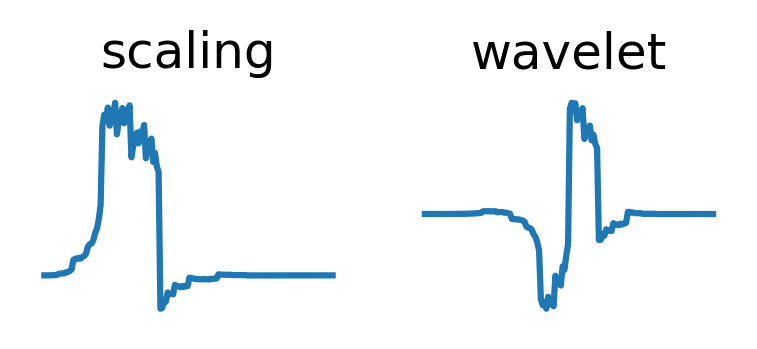

In [8]:
idx1, idx2 = list(dic['index'].keys())[np.argmax(log).flatten()[0]]
wt = mos[dic['index'][(idx1, idx2)]]
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

# print 
print('Hyperparameter: lamL1wave={:.6f} lamL1attr={:.6f}'.format(res['lamL1wave'][dic['index'][(idx1, idx2)]], res['lamL1attr'][dic['index'][(idx1, idx2)]]))
print('Error: Recon={:.6f}'.format(res['rec_loss'][dic['index'][(idx1, idx2)]]))
print('Sparsity: Wave={:.6f}'.format(res['L1wave_loss'][dic['index'][(idx1, idx2)]]))
print('Interp: Saliency={:.6f} InputXGrade={:.6f}'.format(res['L1saliency_loss'][dic['index'][(idx1, idx2)]], res['L1inputxgrad_loss'][dic['index'][(idx1, idx2)]]))
print('Wavelet loss: lSum={:.6f} hsum={:.6f} L2norm={:.6f} CMF={:.6f} Conv={:.6f}'.format(res['lsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['hsum_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['L2norm_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['CMF_loss'][dic['index'][(idx1, idx2)]],
                                                                                          res['conv_loss'][dic['index'][(idx1, idx2)]]))


plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))

In [9]:
model = load_pretrained_model(p.model_path, device=device)    

r = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': [],    
    'LSTM': [],
}

(train_loader, test_loader) = get_dataloader(p.data_path, 
                             batch_size=p.batch_size,
                             is_continuous=False)   

(X, y), (X_test, y_test) = max_transformer(wt, 
                                           train_loader, 
                                           test_loader,
                                           is_abs=is_abs,
                                           m=m)

clf = LogisticRegression().fit(X, y)
preds = clf.predict(X_test)
preds = 1 * (preds > 0)
acc = metrics.accuracy_score(y_test, preds)
r['AWD (Ours)'].append(acc)

(X, y), (X_test, y_test) = max_transformer(wt_o, 
                                           train_loader, 
                                           test_loader,
                                           is_abs=is_abs,
                                           m=m)

clf_o = LogisticRegression().fit(X, y)
preds = clf_o.predict(X_test)
preds = 1 * (preds > 0)
acc = metrics.accuracy_score(y_test, preds)
r['Standard Wavelet (DB5)'].append(acc)


preds = []
y_test = []
for data, labels in test_loader:   
    preds.append(model(data).detach().numpy())
    y_test.append(labels.detach().numpy())
preds = np.vstack(preds)
y_test = np.vstack(y_test)
preds = 1 * (preds > 0)
acc = metrics.accuracy_score(y_test, preds)
r['LSTM'].append(acc)

scores = pd.DataFrame.from_dict(r).round(3)
scores.index = ['Classification accuracy']
print(scores.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Standard Wavelet (DB5) &  AWD (Ours) &   LSTM \\
\midrule
Classification accuracy &                   0.707 &         0.7 &  0.709 \\
\bottomrule
\end{tabular}

